## !Important to do this first to have the effnetv2 model installed!

In [1]:
%%capture
#@title
!pip install tensorflow_addons

import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientnetv2" not in os.getcwd():
    !git clone --depth 1 https://github.com/google/automl
    os.chdir('automl/efficientnetv2')
    sys.path.append('.')
else:
    !git pull

def download(m):
    if m not in os.listdir():
        !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/{m}.tgz
        !tar zxf {m}.tgz
    ckpt_path = os.path.join(os.getcwd(), m)
    return ckpt_path

## Import my modules

Make sure EfficientNet_Functions.py is in the same directory

In [2]:
import EfficientNet_Functions as myfuncs

## Import other necessary libraries

In [3]:
import tensorflow_hub as hub
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import csv
from PIL import Image, ImageFile
import tensorflow as tf
#import tensorflow_datasets as tfds
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Configs

In [4]:
Image.MAX_IMAGE_PIXELS = 1000000000
#data_dir_train = '/projectnb/dl523/students/nannkat/EC520/wikipaintings_full/content/gdrive/Shareddrives/520 Project/Data/wikipaintings_full_aug/train'
data_dir_train = '/projectnb/dl523/projects/Sarcasm/content/gdrive/Shareddrives/520 Project/Data/wikipaintings_full_aug/train'
data_dir_val = '/projectnb/dl523/students/nannkat/EC520/wikipaintings_full/wikipaintings_val'
data_dir_test = '/projectnb/dl523/students/nannkat/EC520/wikipaintings_full/wikipaintings_test'

checkpoint_path = "/projectnb/dl523/students/nannkat/EC520/training/cp_cosine_dec.ckpt"
model_path = '/projectnb/dl523/students/nannkat/EC520/training/effnetv2_model'

IMAGE_SIZE = 223
BATCH_SIZE =  64
LEARNING_RATE = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate = 0.1, decay_steps = 1000)
NUM_EPOCHS = 4

## Import Data

Loading data...

Found 7383 images belonging to 25 classes.
Found 246350 images belonging to 25 classes.
Found 8201 images belonging to 25 classes.
Label map:
{'Abstract_Art': 0, 'Abstract_Expressionism': 1, 'Art_Informel': 2, 'Art_Nouveau_(Modern)': 3, 'Baroque': 4, 'Color_Field_Painting': 5, 'Cubism': 6, 'Early_Renaissance': 7, 'Expressionism': 8, 'High_Renaissance': 9, 'Impressionism': 10, 'Magic_Realism': 11, 'Mannerism_(Late_Renaissance)': 12, 'Minimalism': 13, 'Naive_Art_(Primitivism)': 14, 'Neoclassicism': 15, 'Northern_Renaissance': 16, 'Pop_Art': 17, 'Post-Impressionism': 18, 'Realism': 19, 'Rococo': 20, 'Romanticism': 21, 'Surrealism': 22, 'Symbolism': 23, 'Ukiyo-e': 24}


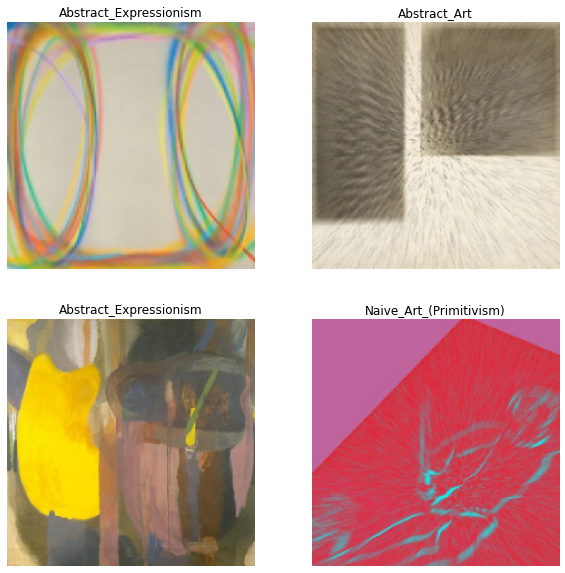

In [5]:
train_generator, valid_generator, test_generator = myfuncs.load_wikidata(data_dir_train, data_dir_val, data_dir_test,
                                                                batch_size = BATCH_SIZE, image_size = IMAGE_SIZE)

myfuncs.visualize_input(train_generator)

## Initialize or restore EffNetV2 model

In [6]:
initialize = True

if initialize:
    model = myfuncs.get_new_model()
else:
    model = myfuncs.restore_model(checkpoint_path, learning_rate = LEARNING_RATE)

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (EffNetV2M  (None, 1280)             117746848 
 odel)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 25)                32025     
                                                                 
Total params: 117,778,873
Trainable params: 32,025
Non-trainable params: 117,746,848
_________________________________________________________________


## Train and Save model

In [ ]:
model, history = myfuncs.train_effnetv2(model, train_generator, valid_generator, num_epochs = NUM_EPOCHS, 
                                learning_rate = LEARNING_RATE, restore = False,
                               checkpoint_path = checkpoint_path, model_path=model_path)

Num GPUs Available:  1
Epoch 1/4
1459/3849 [==========>...................] - ETA: 1:11:02 - loss: 36.8584 - accuracy: 0.2198 - top_k_categorical_accuracy: 0.5780

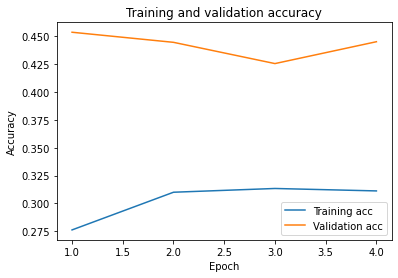

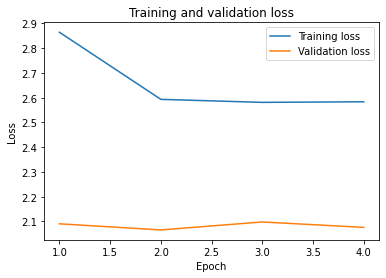

In [8]:
myfuncs.plot_training(history)

## Test and predict

### Evaluate

In [ ]:
test_steps = test_generator.samples // test_generator.batch_size
model.evaluate(test_generator, steps = test_steps)

### Examples

In [ ]:
myfuncs.visualize_results(model, test_generator)

### Predict

In [ ]:
output_path = '/projectnb/dl523/students/nannkat/EC520/preds_vs_true_effnet_1Freeze10epochLr001.csv'
preds, true_labels, preds_df = myfuncs.predict_and_save(model, test_generator, output_path)